In [5]:
# !pip install pygame

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import gymnasium as gym
from gymnasium import spaces
import random
import time
import threading
import collections
from typing import List, Dict, Tuple, Optional

# For visualization
import pygame
from pygame import gfxdraw
import math

# For RL algorithm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal



Episode 10/1000 | Reward: 1101.33 | Avg Reward: 885.60 | Avg Distance: 48.95
Episode 20/1000 | Reward: 875.53 | Avg Reward: 908.01 | Avg Distance: 52.23
Episode 30/1000 | Reward: 631.99 | Avg Reward: 854.24 | Avg Distance: 54.85
Episode 40/1000 | Reward: 808.45 | Avg Reward: 802.69 | Avg Distance: 51.37
Episode 50/1000 | Reward: 1015.76 | Avg Reward: 865.49 | Avg Distance: 46.68
Episode 60/1000 | Reward: 825.94 | Avg Reward: 696.48 | Avg Distance: 50.78
Episode 70/1000 | Reward: 719.18 | Avg Reward: 734.88 | Avg Distance: 52.85
Episode 80/1000 | Reward: 727.64 | Avg Reward: 761.37 | Avg Distance: 52.53
Episode 90/1000 | Reward: 989.61 | Avg Reward: 852.10 | Avg Distance: 48.90
Episode 100/1000 | Reward: 1371.62 | Avg Reward: 975.08 | Avg Distance: 40.22
Episode 110/1000 | Reward: 1130.88 | Avg Reward: 1246.42 | Avg Distance: 45.24
Episode 120/1000 | Reward: 1114.50 | Avg Reward: 1123.61 | Avg Distance: 46.92
Episode 130/1000 | Reward: 1428.54 | Avg Reward: 1421.83 | Avg Distance: 40.16

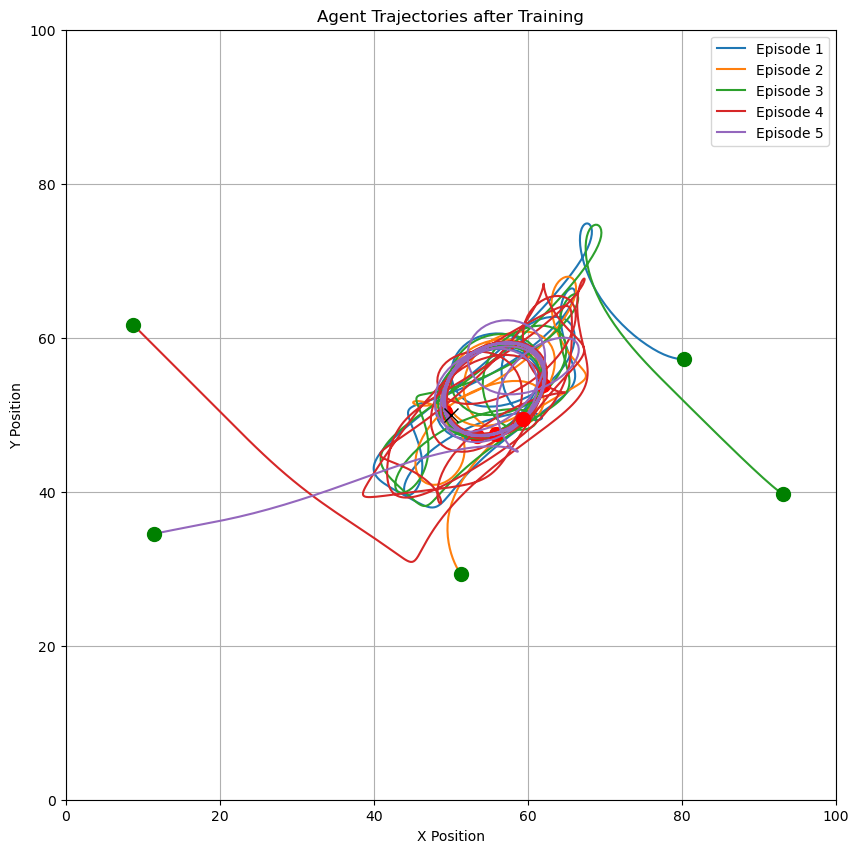

: 

In [ ]:


# Constants
TANK_SIZE = 100  # Size of the tank (square)
CENTER_POINT = np.array([TANK_SIZE/2, TANK_SIZE/2])
MAX_VELOCITY = 30
MAX_FORCE = 10
CURRENT_COUNT = 0  # Number of water currents
MAX_CURRENT_STRENGTH = 5.0
CURRENT_CHANGE_PROB = 0.01  # Probability of current changing direction/strength
CURRENT_RADIUS = 30.0  # Radius of current influence
WATER_RESISTANCE = 0.1  # Resistance factor
TIMESTEP = 0.1  # Physics timestep

# Training parameters
LEARNING_RATE = 0.0005
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPSILON = 0.2
VALUE_COEF = 0.5
ENTROPY_COEF = 0.01
MAX_GRAD_NORM = 0.5
BATCH_SIZE = 256
BUFFER_SIZE = 2048
EPOCHS = 10
UPDATE_FREQUENCY = 2048  # Steps between policy updates

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

class WaterCurrent:
    """Represents a water current in the environment"""
    
    def __init__(self, tank_size: float):
        self.tank_size = tank_size
        self.position = np.random.uniform(0, tank_size, 2)
        self.direction = self._random_direction()
        self.strength = np.random.uniform(1.0, MAX_CURRENT_STRENGTH)
        self.color = np.random.uniform(0, 1, 3)  # Random color for visualization
        self.velocity = np.random.uniform(1.0, 3.0)  # Current movement speed
        
    def _random_direction(self) -> np.ndarray:
        """Generate a random unit vector for direction"""
        angle = np.random.uniform(0, 2 * np.pi)
        return np.array([np.cos(angle), np.sin(angle)])
    
    def update(self):
        """Update current position and possibly direction/strength"""
        # Move the current
        self.position += self.direction * self.velocity * TIMESTEP
        
        # Bounce off walls
        for i in range(2):
            if self.position[i] < 0:
                self.position[i] = 0
                self.direction[i] *= -1
            elif self.position[i] > self.tank_size:
                self.position[i] = self.tank_size
                self.direction[i] *= -1
        
        # Occasionally change direction and strength
        if np.random.random() < CURRENT_CHANGE_PROB:
            self.direction = self._random_direction()
            self.strength = np.random.uniform(1.0, MAX_CURRENT_STRENGTH)
    
    def get_force_at(self, position: np.ndarray) -> np.ndarray:
        """Calculate force exerted by this current at the given position"""
        distance = np.linalg.norm(position - self.position)
        
        # If outside the influence radius, no effect
        if distance > CURRENT_RADIUS:
            return np.zeros(2)
        
        # Force decreases with distance (inverse linear relationship)
        force_magnitude = self.strength * (1 - distance / CURRENT_RADIUS)
        return force_magnitude * self.direction


class FishEnv(gym.Env):
    """Fish environment with water currents"""
    
    metadata = {'render_modes': ['rgb_array']}
    
    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()
        
        # State space: fish position (x,y), fish velocity (vx,vy), and currents
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -MAX_VELOCITY, -MAX_VELOCITY] + [0, 0, -1, -1, 0] * CURRENT_COUNT),
            high=np.array([TANK_SIZE, TANK_SIZE, MAX_VELOCITY, MAX_VELOCITY] + [TANK_SIZE, TANK_SIZE, 1, 1, MAX_CURRENT_STRENGTH] * CURRENT_COUNT),
            dtype=np.float32
        )
        
        # Action space: thrust force in x and y directions
        self.action_space = spaces.Box(
            low=-MAX_FORCE,
            high=MAX_FORCE,
            shape=(2,),
            dtype=np.float32
        )
        
        # Initialize state
        self.fish_position = None
        self.fish_velocity = None
        self.currents = []
        self.steps = 0
        self.max_steps = 1000
        self.render_mode = render_mode
        
        # For visualization
        self.screen = None
        self.clock = None
        
        # For metrics
        self.current_episode_reward = 0
        self.reward_history = []
        self.distance_history = []
        self.episode_rewards = []
        self.episode_lengths = []
        
        # For trajectories
        self.trajectory = []
        
        # Reset the environment
        self.reset()
    
    def _get_obs(self) -> np.ndarray:
        """Convert current state to observation vector"""
        obs = np.concatenate([
            self.fish_position,
            self.fish_velocity
        ])
        
        # Add information about each current
        for current in self.currents:
            current_info = np.concatenate([
                current.position,
                current.direction,
                [current.strength]
            ])
            obs = np.concatenate([obs, current_info])
            
        return obs
    
    def _get_info(self) -> Dict:
        """Get additional information about the state"""
        distance_to_center = np.linalg.norm(self.fish_position - CENTER_POINT)
        
        return {
            "distance_to_center": distance_to_center,
            "step": self.steps,
            "total_reward": self.current_episode_reward
        }
    
    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        """Reset the environment to initial state"""
        super().reset(seed=seed)
        
        # Place fish randomly, but not in the center
        while True:
            self.fish_position = np.random.uniform(0, TANK_SIZE, 2)
            if np.linalg.norm(self.fish_position - CENTER_POINT) > 20:
                break
                
        self.fish_velocity = np.zeros(2)
        
        # Create water currents
        self.currents = [WaterCurrent(TANK_SIZE) for _ in range(CURRENT_COUNT)]
        
        self.steps = 0
        self.current_episode_reward = 0
        self.trajectory = [self.fish_position.copy()]
        
        return self._get_obs(), self._get_info()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Take a step in the environment given an action"""
        self.steps += 1
        
        # Apply the action (thrust force)
        action = np.clip(action, -MAX_FORCE, MAX_FORCE)
        
        # Calculate water current forces
        current_force = np.zeros(2)
        for current in self.currents:
            current.update()
            current_force += current.get_force_at(self.fish_position)
        
        # Calculate total force and update velocity
        total_force = action + current_force
        water_resistance_force = -WATER_RESISTANCE * self.fish_velocity * np.abs(self.fish_velocity)
        
        # Update velocity using forces
        self.fish_velocity += (total_force + water_resistance_force) * TIMESTEP
        self.fish_velocity = np.clip(self.fish_velocity, -MAX_VELOCITY, MAX_VELOCITY)
        
        # Update position
        new_position = self.fish_position + self.fish_velocity * TIMESTEP
        
        # Handle bouncing off walls
        for i in range(2):
            if new_position[i] < 0:
                new_position[i] = 0
                self.fish_velocity[i] *= -0.5  # Lose energy when hitting wall
            elif new_position[i] > TANK_SIZE:
                new_position[i] = TANK_SIZE
                self.fish_velocity[i] *= -0.5  # Lose energy when hitting wall
        
        self.fish_position = new_position
        self.trajectory.append(self.fish_position.copy())
        
        # Calculate reward
        distance_to_center = np.linalg.norm(self.fish_position - CENTER_POINT)
        
        # Exponential reward for being close to center (higher reward when very close)
        position_reward = 10 * np.exp(-0.05 * distance_to_center)
        
        # Penalty for high velocity (encourage stability)
        velocity_penalty = -0.01 * np.linalg.norm(self.fish_velocity)
        
        # Penalty for using thrust (encourage efficiency)
        thrust_penalty = -0.005 * np.linalg.norm(action)
        
        reward = position_reward + velocity_penalty + thrust_penalty
        self.current_episode_reward += reward
        
        # For metrics
        self.reward_history.append(reward)
        self.distance_history.append(distance_to_center)
        
        # Check if episode is done
        done = self.steps >= self.max_steps
        
        if done:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.steps)
        
        return self._get_obs(), reward, done, False, self._get_info()
    
    def render(self):
        """Render the environment"""
        if self.render_mode == 'rgb_array':
            return self._render_frame()
    
    def _render_frame(self):
        """Render a frame for visualization"""
        if self.screen is None:
            # Initialize pygame screen
            pygame.init()
            pygame.display.init()
            self.screen = pygame.Surface((TANK_SIZE * 7, TANK_SIZE * 7))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((255, 255, 255))
        
        # Scale factor for visualization
        scale = 7
        
        # Draw border
        pygame.draw.rect(self.screen, (0, 0, 0), pygame.Rect(0, 0, TANK_SIZE * scale, TANK_SIZE * scale), 2)
        
        # Draw target center
        pygame.draw.circle(self.screen, (255, 200, 200), (CENTER_POINT[0] * scale, CENTER_POINT[1] * scale), 10)
        
        # Draw currents (as circles with arrows)
        for current in self.currents:
            x, y = current.position * scale
            
            # Draw current influence area
            transparency = 50  # Alpha value
            s = pygame.Surface((CURRENT_RADIUS * 2 * scale, CURRENT_RADIUS * 2 * scale), pygame.SRCALPHA)
            color = tuple(int(c * 255) for c in current.color) + (transparency,)
            pygame.draw.circle(s, color, (CURRENT_RADIUS * scale, CURRENT_RADIUS * scale), CURRENT_RADIUS * scale)
            self.screen.blit(s, (x - CURRENT_RADIUS * scale, y - CURRENT_RADIUS * scale))
            
            # Draw arrow showing direction and strength
            end_x = x + current.direction[0] * current.strength * 5
            end_y = y + current.direction[1] * current.strength * 5
            pygame.draw.line(self.screen, (0, 0, 0), (x, y), (end_x, end_y), 2)
            
            # Draw arrowhead
            arrow_length = 7
            angle = math.atan2(end_y - y, end_x - x)
            pygame.draw.polygon(self.screen, (0, 0, 0), [
                (end_x, end_y),
                (end_x - arrow_length * math.cos(angle - math.pi/6), end_y - arrow_length * math.sin(angle - math.pi/6)),
                (end_x - arrow_length * math.cos(angle + math.pi/6), end_y - arrow_length * math.sin(angle + math.pi/6))
            ])
        
        # Draw fish
        fish_x, fish_y = self.fish_position * scale
        fish_size = 6
        
        # Draw fish body as a circle
        pygame.draw.circle(self.screen, (0, 100, 255), (fish_x, fish_y), fish_size)
        
        # Draw fish "face" showing direction of motion
        if np.linalg.norm(self.fish_velocity) > 0.1:
            direction = self.fish_velocity / np.linalg.norm(self.fish_velocity)
            eye_x = fish_x + direction[0] * fish_size * 0.7
            eye_y = fish_y + direction[1] * fish_size * 0.7
            pygame.draw.circle(self.screen, (255, 255, 255), (eye_x, eye_y), fish_size * 0.4)
        
        # Convert to RGB array
        observation = np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )
        return observation


class ReplayMemory:
    """Replay buffer for storing experience"""
    
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size: int):
        """Sample random batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self) -> int:
        return len(self.buffer)


class PolicyNetwork(nn.Module):
    """Actor-Critic network for PPO algorithm"""
    
    def __init__(self, obs_size: int, action_size: int):
        super(PolicyNetwork, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Actor (policy) head
        self.actor_mean = nn.Linear(128, action_size)
        self.actor_logstd = nn.Parameter(torch.zeros(action_size))
        
        # Critic (value) head
        self.critic = nn.Linear(128, 1)
    
    def forward(self, x):
        """Forward pass through network"""
        x = torch.FloatTensor(x)
        shared_features = self.shared(x)
        
        # Actor output (action mean and std)
        action_mean = self.actor_mean(shared_features)
        action_std = torch.exp(self.actor_logstd)
        
        # Critic output (state value)
        value = self.critic(shared_features)
        
        return action_mean, action_std, value
    
    def get_action(self, state, deterministic=False):
        """Sample action from policy"""
        with torch.no_grad():
            action_mean, action_std, _ = self.forward(state)
            
            if deterministic:
                return action_mean.numpy()
            
            dist = Normal(action_mean, action_std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
            
            return action.numpy(), log_prob.numpy()
    
    def evaluate_actions(self, states, actions):
        """Evaluate actions for PPO update"""
        action_mean, action_std, values = self.forward(states)
        
        dist = Normal(action_mean, action_std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1).mean()
        
        return log_probs, values.squeeze(), entropy


class PPOAgent:
    """PPO Agent implementation"""
    
    def __init__(self, env):
        self.env = env
        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.shape[0]
        
        self.policy = PolicyNetwork(obs_size, action_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=LEARNING_RATE)
        
        self.memory = []
        self.training_step = 0
        
        self.running_rewards = collections.deque(maxlen=100)
        self.running_lengths = collections.deque(maxlen=100)
        
        # Metrics
        self.avg_rewards = []
        self.avg_lengths = []
        self.policy_losses = []
        self.value_losses = []
        self.entropies = []
    
    def store_transition(self, state, action, action_log_prob, reward, done, value):
        """Store transition in memory"""
        self.memory.append((state, action, action_log_prob, reward, done, value))
    
    def update(self):
        """Update policy using PPO algorithm"""
        memory = self.memory
        self.memory = []
        
        states = np.array([m[0] for m in memory])
        actions = np.array([m[1] for m in memory])
        old_log_probs = np.array([m[2] for m in memory])
        rewards = np.array([m[3] for m in memory])
        dones = np.array([m[4] for m in memory])
        values = np.array([m[5] for m in memory])
        
        # Compute advantages using GAE
        returns = []
        advantages = []
        gae = 0
        
        for i in reversed(range(len(rewards))):
            if dones[i]:
                next_value = 0
            else:
                next_value = values[i+1] if i < len(rewards)-1 else 0
                
            delta = rewards[i] + GAMMA * next_value * (1 - dones[i]) - values[i]
            gae = delta + GAMMA * GAE_LAMBDA * (1 - dones[i]) * gae
            
            returns.insert(0, gae + values[i])
            advantages.insert(0, gae)
        
        returns = np.array(returns)
        advantages = np.array(advantages)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Convert to PyTorch tensors
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        returns = torch.FloatTensor(returns)
        advantages = torch.FloatTensor(advantages)
        
        # PPO update loop
        policy_loss_epoch = 0
        value_loss_epoch = 0
        entropy_epoch = 0
        
        for _ in range(EPOCHS):
            # Get random permutation of indices
            indices = torch.randperm(len(states))
            
            # Mini-batch update
            for start_idx in range(0, len(states), BATCH_SIZE):
                idx = indices[start_idx:start_idx + BATCH_SIZE]
                
                batch_states = states[idx]
                batch_actions = actions[idx]
                batch_old_log_probs = old_log_probs[idx]
                batch_returns = returns[idx]
                batch_advantages = advantages[idx]
                
                # Evaluate actions
                log_probs, values, entropy = self.policy.evaluate_actions(batch_states, batch_actions)
                
                # Policy loss
                ratio = torch.exp(log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - CLIP_EPSILON, 1.0 + CLIP_EPSILON) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss
                value_loss = 0.5 * ((values - batch_returns) ** 2).mean()
                
                # Total loss
                loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy
                
                # Optimize
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), MAX_GRAD_NORM)
                self.optimizer.step()
                
                policy_loss_epoch += policy_loss.item()
                value_loss_epoch += value_loss.item()
                entropy_epoch += entropy.item()
            
        # Update metrics
        self.policy_losses.append(policy_loss_epoch / EPOCHS)
        self.value_losses.append(value_loss_epoch / EPOCHS)
        self.entropies.append(entropy_epoch / EPOCHS)
        
        self.training_step += 1
        
        return policy_loss_epoch / EPOCHS, value_loss_epoch / EPOCHS, entropy_epoch / EPOCHS
    
    def train(self, num_episodes, update_freq=UPDATE_FREQUENCY, visualize=False, real_time=True):
        """Train the agent"""
        self.running_rewards = collections.deque(maxlen=100)
        self.running_lengths = collections.deque(maxlen=100)
        
        total_steps = 0
        
        # Visualization setup
        if visualize:
            plt.ion()  # Turn on interactive mode
            fig = plt.figure(figsize=(18, 10))
            gs = GridSpec(2, 3, figure=fig)
            
            # Main environment display
            ax_env = fig.add_subplot(gs[:, 0])
            ax_env.set_xlim(0, TANK_SIZE)
            ax_env.set_ylim(0, TANK_SIZE)
            ax_env.set_aspect('equal')
            ax_env.set_title('Fish Environment')
            
            # Plot center target
            center_circle = plt.Circle(CENTER_POINT, 3, color='r', alpha=0.3)
            ax_env.add_artist(center_circle)
            
            # Plot fish and currents
            fish_plot, = ax_env.plot([], [], 'bo', markersize=8)
            current_plots = []
            quiver_plots = []
            for _ in range(CURRENT_COUNT):
                current_plots.append(plt.Circle((0, 0), CURRENT_RADIUS, color='gray', alpha=0.2))
                quiver_plots.append(ax_env.quiver(0, 0, 0, 0, color='gray', scale=20))
                ax_env.add_artist(current_plots[-1])
            
            # Plot trajectory
            traj_plot, = ax_env.plot([], [], 'b-', alpha=0.5)
            
            # Plot reward history
            ax_reward = fig.add_subplot(gs[0, 1])
            ax_reward.set_title('Episode Reward')
            ax_reward.set_xlabel('Episode')
            ax_reward.set_ylabel('Total Reward')
            reward_plot, = ax_reward.plot([], [], 'g-')
            
            # Plot avg distance to center
            ax_dist = fig.add_subplot(gs[0, 2])
            ax_dist.set_title('Distance to Center')
            ax_dist.set_xlabel('Step')
            ax_dist.set_ylabel('Distance')
            dist_plot, = ax_dist.plot([], [], 'r-')
            
            # Plot policy loss
            ax_policy = fig.add_subplot(gs[1, 1])
            ax_policy.set_title('Policy Loss')
            ax_policy.set_xlabel('Update')
            ax_policy.set_ylabel('Loss')
            policy_plot, = ax_policy.plot([], [], 'b-')
            
            # Plot value loss
            ax_value = fig.add_subplot(gs[1, 2])
            ax_value.set_title('Value Loss')
            ax_value.set_xlabel('Update')
            ax_value.set_ylabel('Loss')
            value_plot, = ax_value.plot([], [], 'r-')
            
            plt.tight_layout()
            plt.show()
        
        # Training loop
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            steps = 0
            
            # Reset episode trajectory
            self.env.trajectory = [self.env.fish_position.copy()]
            
            while not done:
                # Select action
                action, log_prob = self.policy.get_action(state)
                
                # Get value estimate
                with torch.no_grad():
                    _, _, value = self.policy.forward(state)
                    value = value.numpy()[0]
                
                # Take step in environment
                next_state, reward, done, _, info = self.env.step(action)
                
                # Store transition
                self.store_transition(state, action, log_prob, reward, done, value)
                
                state = next_state
                episode_reward += reward
                steps += 1
                total_steps += 1
                
                # Update if memory is full
                if total_steps % update_freq == 0:
                    self.update()
                
                # Visualization
                if visualize and (real_time or done):
                    # Update fish position
                    fish_plot.set_data([self.env.fish_position[0]], [self.env.fish_position[1]])
                    
                    # Update currents
                    for i, current in enumerate(self.env.currents):
                        current_plots[i].center = current.position
                        quiver_plots[i].set_offsets([current.position[0], current.position[1]])
                        quiver_plots[i].set_UVC(current.direction[0] * current.strength, 
                                              current.direction[1] * current.strength)
                    
                    # Update trajectory
                    traj_x = [pos[0] for pos in self.env.trajectory]
                    traj_y = [pos[1] for pos in self.env.trajectory]
                    traj_plot.set_data(traj_x, traj_y)
                    
                    # Update metrics plots if we have data
                    if self.env.episode_rewards:
                        reward_plot.set_data(range(len(self.env.episode_rewards)), self.env.episode_rewards)
                        ax_reward.relim()
                        ax_reward.autoscale_view()
                    
                    if self.env.distance_history:
                        steps_array = np.arange(len(self.env.distance_history))
                        # Use moving average for smoother plot
                        window_size = min(50, len(self.env.distance_history))
                        if window_size > 1:
                            smooth_dist = np.convolve(self.env.distance_history, 
                                                   np.ones(window_size)/window_size, 
                                                   mode='valid')
                            dist_plot.set_data(steps_array[window_size-1:], smooth_dist)
                        else:
                            dist_plot.set_data(steps_array, self.env.distance_history)
                        ax_dist.relim()
                        ax_dist.autoscale_view()
                    
                    if self.policy_losses:
                        policy_plot.set_data(range(len(self.policy_losses)), self.policy_losses)
                        ax_policy.relim()
                        ax_policy.autoscale_view()
                        
                        value_plot.set_data(range(len(self.value_losses)), self.value_losses)
                        ax_value.relim()
                        ax_value.autoscale_view()
                    
                    plt.draw()
                    plt.pause(0.001)
            
            # Episode finished
            self.running_rewards.append(episode_reward)
            self.running_lengths.append(steps)
            
            self.avg_rewards.append(np.mean(self.running_rewards))
            self.avg_lengths.append(np.mean(self.running_lengths))
            
            # Print progress
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{num_episodes} | " 
                      f"Avg Reward: {self.avg_rewards[-1]:.2f} | "
                      f"Avg Length: {self.avg_lengths[-1]:.2f}")
        
        if visualize:
            plt.ioff()  # Turn off interactive mode
        
        return self.avg_rewards, self.avg_lengths


def run_visualization(env, agent, episodes=5):
    """Run visualization of trained agent"""
    plt.figure(figsize=(10, 10))
    
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        
        # Store trajectory
        trajectory = [env.fish_position.copy()]
        
        while not done:
            # Select action (deterministic for visualization)
            action = agent.policy.get_action(state, deterministic=True)
            if isinstance(action, tuple):
                action = action[0]
            
            # Take step in environment
            next_state, reward, done, _, _ = env.step(action)
            
            state = next_state
            episode_reward += reward
            
            # Store position for trajectory
            trajectory.append(env.fish_position.copy())
        
        # Plot the trajectory
        trajectory = np.array(trajectory)
        plt.plot(trajectory[:, 0], trajectory[:, 1], '-', label=f'Episode {episode+1}')
        
        # Plot start and end points
        plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10)
        plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=10)
    
    # Plot center point
    plt.plot(CENTER_POINT[0], CENTER_POINT[1], 'kx', markersize=10)
    
    plt.xlim(0, TANK_SIZE)
    plt.ylim(0, TANK_SIZE)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.title(f'Agent Trajectories after Training')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.show()


class RealTimeTrainer:
    """Real-time visualization of the learning process"""
    
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.running = False
        self.training_thread = None
        
        # Initialize pygame
        pygame.init()
        self.screen_size = 800
        self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
        pygame.display.set_caption("Fish RL - Real-time Learning")
        self.clock = pygame.time.Clock()
        
        # Metrics tracking
        self.episode_rewards = []
        self.episode_distances = []
        self.distance_history = []
        self.avg_reward_history = []
        self.policy_loss_history = []
        self.value_loss_history = []
        
        # For showing info on screen
        self.font = pygame.font.SysFont('Arial', 18)
        self.large_font = pygame.font.SysFont('Arial', 24)
        
        # Current episode metrics
        self.current_episode = 0
        self.current_step = 0
        self.total_steps = 0
        self.last_update_step = 0
        
        # Scaling for visualization
        self.scale = self.screen_size / TANK_SIZE
    
    def start_training(self, num_episodes=1000, update_frequency=UPDATE_FREQUENCY):
        """Start training in a separate thread"""
        if self.running:
            return
        
        self.running = True
        self.training_thread = threading.Thread(
            target=self._training_loop,
            args=(num_episodes, update_frequency),
            daemon=True
        )
        self.training_thread.start()
    
    def _training_loop(self, num_episodes, update_frequency):
        """Main training loop running in separate thread"""
        for episode in range(num_episodes):
            if not self.running:
                break
                
            self.current_episode = episode + 1
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            self.current_step = 0
            
            # Calculate average distance for this episode
            episode_distances = []
            
            while not done and self.running:
                # Select action
                action, log_prob = self.agent.policy.get_action(state)
                
                # Get value estimate
                with torch.no_grad():
                    _, _, value = self.agent.policy.forward(state)
                    value = value.numpy()[0]
                
                # Take step in environment
                next_state, reward, done, _, info = self.env.step(action)
                
                # Calculate distance to center
                distance = info['distance_to_center']
                episode_distances.append(distance)
                self.distance_history.append(distance)
                
                # Store transition
                self.agent.store_transition(state, action, log_prob, reward, done, value)
                
                state = next_state
                episode_reward += reward
                self.current_step += 1
                self.total_steps += 1
                
                # Update policy if memory is full
                if self.total_steps % update_frequency == 0:
                    policy_loss, value_loss, _ = self.agent.update()
                    self.policy_loss_history.append(policy_loss)
                    self.value_loss_history.append(value_loss)
                    self.last_update_step = self.total_steps
                
                # Short sleep to not hog CPU
                time.sleep(0.001)
            
            # Episode finished
            self.episode_rewards.append(episode_reward)
            
            # Calculate average distance for this episode
            avg_distance = np.mean(episode_distances) if episode_distances else 0
            self.episode_distances.append(avg_distance)
            
            # Calculate average reward over last 10 episodes
            window_size = min(10, len(self.episode_rewards))
            avg_reward = np.mean(self.episode_rewards[-window_size:])
            self.avg_reward_history.append(avg_reward)
            
            # Print progress
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{num_episodes} | " 
                      f"Reward: {episode_reward:.2f} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Avg Distance: {avg_distance:.2f}")
        
        print("Training finished")
        self.running = False
    
    def run_visualization(self):
        """Run the real-time visualization"""
        running = True
        
        # Colors
        WHITE = (255, 255, 255)
        BLACK = (0, 0, 0)
        BLUE = (0, 100, 255)
        RED = (255, 0, 0)
        GREEN = (0, 200, 0)
        GRAY = (200, 200, 200)
        
        while running:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                    self.running = False
            
            # Clear the screen
            self.screen.fill(WHITE)
            
            # Draw border
            pygame.draw.rect(self.screen, BLACK, pygame.Rect(0, 0, self.screen_size, self.screen_size), 2)
            
            # Draw target center
            center_x, center_y = CENTER_POINT * self.scale
            pygame.draw.circle(self.screen, (255, 200, 200), (center_x, center_y), 20)
            pygame.draw.circle(self.screen, RED, (center_x, center_y), 5)
            
            if hasattr(self.env, 'fish_position') and self.env.fish_position is not None:
                # Draw currents
                for current in self.env.currents:
                    x, y = current.position * self.scale
                    
                    # Draw current influence area
                    transparency = 50  # Alpha value
                    s = pygame.Surface((CURRENT_RADIUS * 2 * self.scale, CURRENT_RADIUS * 2 * self.scale), pygame.SRCALPHA)
                    color = tuple(int(c * 255) for c in current.color) + (transparency,)
                    pygame.draw.circle(s, color, (CURRENT_RADIUS * self.scale, CURRENT_RADIUS * self.scale), CURRENT_RADIUS * self.scale)
                    self.screen.blit(s, (x - CURRENT_RADIUS * self.scale, y - CURRENT_RADIUS * self.scale))
                    
                    # Draw arrow showing direction and strength
                    end_x = x + current.direction[0] * current.strength * 10
                    end_y = y + current.direction[1] * current.strength * 10
                    pygame.draw.line(self.screen, BLACK, (x, y), (end_x, end_y), 2)
                    
                    # Draw arrowhead
                    arrow_length = 10
                    angle = math.atan2(end_y - y, end_x - x)
                    pygame.draw.polygon(self.screen, BLACK, [
                        (end_x, end_y),
                        (end_x - arrow_length * math.cos(angle - math.pi/6), end_y - arrow_length * math.sin(angle - math.pi/6)),
                        (end_x - arrow_length * math.cos(angle + math.pi/6), end_y - arrow_length * math.sin(angle + math.pi/6))
                    ])
                
                # Draw fish
                fish_x, fish_y = self.env.fish_position * self.scale
                fish_size = 12
                
                # Draw fish body as a circle
                pygame.draw.circle(self.screen, BLUE, (fish_x, fish_y), fish_size)
                
                # Draw fish "face" showing direction of motion
                if np.linalg.norm(self.env.fish_velocity) > 0.1:
                    direction = self.env.fish_velocity / np.linalg.norm(self.env.fish_velocity)
                    eye_x = fish_x + direction[0] * fish_size * 0.7
                    eye_y = fish_y + direction[1] * fish_size * 0.7
                    pygame.draw.circle(self.screen, WHITE, (eye_x, eye_y), fish_size * 0.4)
                
                # Draw trajectory as a fading line
                if len(self.env.trajectory) > 2:
                    traj_points = [(p[0] * self.scale, p[1] * self.scale) for p in self.env.trajectory]
                    
                    # Use alpha to create a fading effect for older trajectory points
                    max_points = min(50, len(traj_points))
                    for i in range(1, max_points):
                        alpha = int(255 * (i / max_points))
                        pygame.draw.line(
                            self.screen, 
                            (*BLUE[:3], alpha), 
                            traj_points[-i], 
                            traj_points[-i-1], 
                            2
                        )
            
            # Draw metrics on screen
            # 1. Episode info
            episode_text = self.large_font.render(f"Episode: {self.current_episode} Step: {self.current_step}", True, BLACK)
            self.screen.blit(episode_text, (10, 10))
            
            # 2. Total steps and updates
            steps_text = self.font.render(f"Total Steps: {self.total_steps} Last Update: {self.last_update_step}", True, BLACK)
            self.screen.blit(steps_text, (10, 40))
            
            # 3. Current distance to center if available
            if hasattr(self.env, 'fish_position') and self.env.fish_position is not None:
                distance = np.linalg.norm(self.env.fish_position - CENTER_POINT)
                dist_text = self.font.render(f"Distance to Center: {distance:.2f}", True, BLACK)
                self.screen.blit(dist_text, (10, 70))
            
            # 4. Average reward (last 10 episodes)
            if self.avg_reward_history:
                reward_text = self.font.render(f"Avg Reward (10 ep): {self.avg_reward_history[-1]:.2f}", True, BLACK)
                self.screen.blit(reward_text, (10, 100))
            
            # 5. Policy loss
            if self.policy_loss_history:
                policy_text = self.font.render(f"Policy Loss: {self.policy_loss_history[-1]:.4f}", True, BLACK)
                self.screen.blit(policy_text, (10, 130))
            
            # Draw metrics graphs if we have data
            margin = 20
            graph_width = 350
            graph_height = 150
            
            if len(self.episode_rewards) > 1:
                # Draw reward history graph
                self._draw_graph(
                    self.screen,
                    self.episode_rewards,
                    "Episode Rewards",
                    self.screen_size - graph_width - margin,
                    margin,
                    graph_width,
                    graph_height,
                    GREEN
                )
            
            if len(self.episode_distances) > 1:
                # Draw distance history graph
                self._draw_graph(
                    self.screen,
                    self.episode_distances,
                    "Avg Distance to Center",
                    self.screen_size - graph_width - margin,
                    margin * 2 + graph_height,
                    graph_width,
                    graph_height,
                    RED,
                    lower_is_better=True
                )
            
            if len(self.policy_loss_history) > 1:
                # Draw policy loss graph
                self._draw_graph(
                    self.screen,
                    self.policy_loss_history,
                    "Policy Loss",
                    self.screen_size - graph_width - margin,
                    margin * 3 + graph_height * 2,
                    graph_width,
                    graph_height,
                    BLUE,
                    lower_is_better=True
                )
            
            # Update display
            pygame.display.flip()
            self.clock.tick(60)  # 60 FPS
        
        pygame.quit()
    
    def _draw_graph(self, surface, data, title, x, y, width, height, color, lower_is_better=False):
        """Draw a simple line graph on the surface"""
        # Colors
        WHITE = (255, 255, 255)
        BLACK = (0, 0, 0)
        GRAY = (200, 200, 200)
        
        # Draw background
        pygame.draw.rect(surface, WHITE, pygame.Rect(x, y, width, height))
        pygame.draw.rect(surface, BLACK, pygame.Rect(x, y, width, height), 1)
        
        # Draw title
        title_text = self.font.render(title, True, BLACK)
        surface.blit(title_text, (x + 5, y + 5))
        
        # Get data for graph
        if len(data) <= 1:
            return
            
        # Draw axes
        pygame.draw.line(surface, GRAY, (x + 30, y + 30), (x + 30, y + height - 10), 1)  # Y-axis
        pygame.draw.line(surface, GRAY, (x + 30, y + height - 10), (x + width - 10, y + height - 10), 1)  # X-axis
        
        # Use only last 100 points for better visualization
        if len(data) > 100:
            plot_data = data[-100:]
        else:
            plot_data = data
        
        # Calculate min/max values
        data_min = min(plot_data)
        data_max = max(plot_data)
        data_range = data_max - data_min
        
        # To avoid division by zero
        if data_range == 0:
            data_range = 1
        
        # Calculate scale
        x_scale = (width - 50) / len(plot_data)
        y_scale = (height - 50) / data_range
        
        # Calculate points
        points = []
        for i, value in enumerate(plot_data):
            point_x = x + 30 + i * x_scale
            # Invert Y if lower is better
            if lower_is_better:
                point_y = y + height - 10 - (value - data_min) * y_scale
            else:
                point_y = y + height - 10 - (value - data_min) * y_scale
            points.append((point_x, point_y))
        
        # Draw line
        if len(points) > 1:
            pygame.draw.lines(surface, color, False, points, 2)
        
        # Draw min/max values
        min_text = self.font.render(f"{data_min:.2f}", True, BLACK)
        max_text = self.font.render(f"{data_max:.2f}", True, BLACK)
        surface.blit(min_text, (x + 5, y + height - 25))
        surface.blit(max_text, (x + 5, y + 35))


def main():
    """Main function to run the fish RL training"""
    # Create environment
    env = FishEnv()
    
    # Create agent
    agent = PPOAgent(env)
    
    # Create real-time trainer
    trainer = RealTimeTrainer(env, agent)
    
    # Start training in background thread
    trainer.start_training(num_episodes=1000)
    
    # Run visualization
    trainer.run_visualization()
    
    # After visualization is closed, we can save the trained model
    torch.save(agent.policy.state_dict(), "fish_policy.pt")
    
    # Run a few episodes with the trained agent
    run_visualization(env, agent)


if __name__ == "__main__":
    main()

Episode 10  avgR=-8499.3  len=1000
Episode 20  avgR=-9242.1  len=1000
Episode 30  avgR=-9201.5  len=1000
Episode 40  avgR=-9094.7  len=1000
Episode 50  avgR=-9357.3  len=1000
Episode 60  avgR=-9272.1  len=1000
Episode 70  avgR=-9339.9  len=1000
Episode 80  avgR=-9260.8  len=1000
Episode 90  avgR=-9106.8  len=1000
Episode 100  avgR=-9378.0  len=1000
Episode 110  avgR=-9116.0  len=1000
Episode 120  avgR=-9124.2  len=1000
Episode 130  avgR=-8960.4  len=1000
Episode 140  avgR=-8523.6  len=1000
Episode 150  avgR=-9061.3  len=1000
Episode 160  avgR=-9302.3  len=1000
Episode 170  avgR=-9392.0  len=1000
Episode 180  avgR=-9507.8  len=1000
Episode 190  avgR=-9141.4  len=1000
Episode 200  avgR=-9358.8  len=1000
Episode 210  avgR=-9458.9  len=1000
Episode 220  avgR=-9114.3  len=1000
Episode 230  avgR=-9143.7  len=1000
Episode 240  avgR=-9407.1  len=1000
Episode 250  avgR=-9242.8  len=1000
Episode 260  avgR=-9414.4  len=1000
Episode 270  avgR=-9398.1  len=1000
Episode 280  avgR=-9015.6  len=1000
E

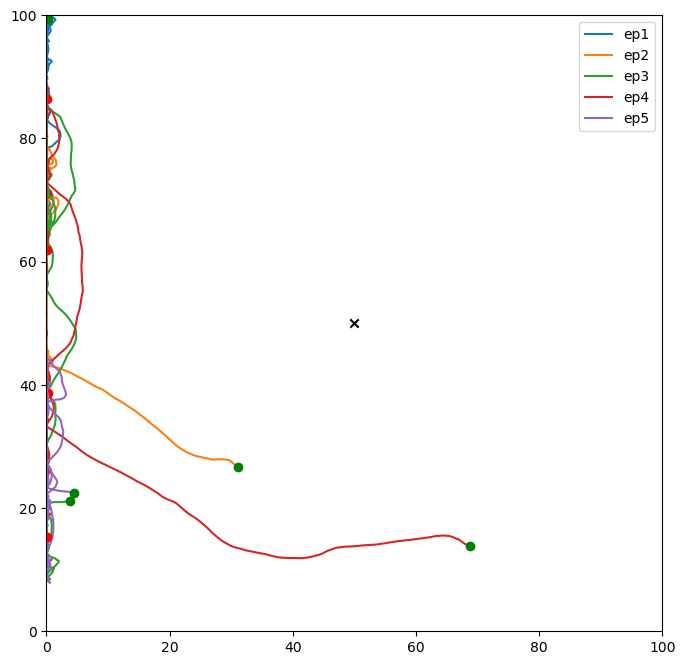

In [2]:
"""
Self‑contained Fish RL script (gym‑style env + PPO + real‑time pygame viewer).
Drop this file in JupyterLab or run via:  python fish_rl_full.py
Requires: numpy, gymnasium, pygame, matplotlib, torch.
"""

import math
import time
import random
import threading
import collections
from typing import Dict, Optional, Tuple

import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pygame
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# ──────────────────────────────────────────────────────────────────────────────
# Constants & Hyper‑parameters
# ──────────────────────────────────────────────────────────────────────────────
TANK_SIZE               = 100
CENTER_POINT            = np.array([TANK_SIZE / 2, TANK_SIZE / 2])
MAX_VELOCITY            = 30
MAX_FORCE               = 10

CURRENT_COUNT           = 3
MAX_CURRENT_STRENGTH    = 3.0
CURRENT_CHANGE_PROB     = 0.01
CURRENT_RADIUS          = 30.0
WATER_RESISTANCE        = 0.1
TIMESTEP                = 0.1

LEARNING_RATE           = 3e-4
GAMMA                   = 0.99
GAE_LAMBDA              = 0.95
CLIP_EPSILON            = 0.2
VALUE_COEF              = 0.5
ENTROPY_COEF            = 0.005
MAX_GRAD_NORM           = 0.5
BATCH_SIZE              = 256
BUFFER_SIZE             = 1024
EPOCHS                  = 4
UPDATE_FREQUENCY        = 1024

# Seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ──────────────────────────────────────────────────────────────────────────────
# Environment pieces
# ──────────────────────────────────────────────────────────────────────────────
class WaterCurrent:
    """Simple moving current."""
    def __init__(self, tank_size: float):
        self.tank_size = tank_size
        self.position  = np.random.uniform(0, tank_size, 2)
        self.direction = self._rand_dir()
        self.strength  = np.random.uniform(1.0, MAX_CURRENT_STRENGTH)
        self.color     = np.random.uniform(0, 1, 3)
        self.velocity  = np.random.uniform(1.0, 3.0)

    @staticmethod
    def _rand_dir():
        ang = np.random.uniform(0, 2 * np.pi)
        return np.array([math.cos(ang), math.sin(ang)])

    def update(self):
        self.position += self.direction * self.velocity * TIMESTEP
        for i in range(2):
            if self.position[i] < 0:
                self.position[i] = 0; self.direction[i] *= -1
            elif self.position[i] > self.tank_size:
                self.position[i] = self.tank_size; self.direction[i] *= -1
        if np.random.rand() < CURRENT_CHANGE_PROB:
            self.direction = self._rand_dir()
            self.strength  = np.random.uniform(1.0, MAX_CURRENT_STRENGTH)

    def get_force_at(self, pos: np.ndarray) -> np.ndarray:
        dist = np.linalg.norm(pos - self.position)
        if dist > CURRENT_RADIUS:
            return np.zeros(2)
        mag = self.strength * (1 - dist / CURRENT_RADIUS)
        return mag * self.direction

# -----------------------------------------------------------------------------
class FishEnv(gym.Env):
    """2‑D fish that tries to reach tank center"""

    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()

        # Normalised observation (all values ∈[‑1,1] or [0,1])
        low  = np.array([0, 0,           # pos 0‑1
                         -1, -1] +       # vel ‑1..1
                         ([0, 0, -1, -1, 0] * CURRENT_COUNT), dtype=np.float32)
        high = np.array([1, 1,
                         1, 1] +
                         ([1, 1, 1, 1, 1] * CURRENT_COUNT), dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.action_space      = spaces.Box(-MAX_FORCE, MAX_FORCE, (2,), np.float32)

        self.render_mode = render_mode
        self.max_steps   = 1000
        self.reset()

        # pygame helpers
        self._screen = None
        self._clock  = None

    # ----- Helpers -----------------------------------------------------------
    def _obs(self) -> np.ndarray:
        pos = self.fish_pos / TANK_SIZE
        vel = self.fish_vel / MAX_VELOCITY
        parts = [pos, vel]
        for cur in self.currents:
            parts.extend([
                cur.position / TANK_SIZE,
                cur.direction,
                np.array([cur.strength / MAX_CURRENT_STRENGTH])
            ])
        return np.concatenate(parts).astype(np.float32)

    def _info(self) -> Dict:
        return {"distance_to_center": float(np.linalg.norm(self.fish_pos - CENTER_POINT)),
                "step": self.steps}

    # ----- Gym API -----------------------------------------------------------
    def reset(self, *, seed: Optional[int] = None, options=None):
        super().reset(seed=seed)
        # spawn away from centre
        while True:
            self.fish_pos = np.random.uniform(0, TANK_SIZE, 2)
            if np.linalg.norm(self.fish_pos - CENTER_POINT) > 20:
                break
        self.fish_vel = np.zeros(2, dtype=float)
        self.currents = [WaterCurrent(TANK_SIZE) for _ in range(CURRENT_COUNT)]
        self.steps    = 0
        self.trajectory = [self.fish_pos.copy()]
        return self._obs(), self._info()

    def step(self, action: np.ndarray):
        self.steps += 1
        # env **does not** clip; assume actor sent in‑range values
        thrust = np.clip(action, -MAX_FORCE, MAX_FORCE)

        # water forces
        cur_force = np.zeros(2)
        for cur in self.currents:
            cur.update(); cur_force += cur.get_force_at(self.fish_pos)

        water_drag  = -WATER_RESISTANCE * self.fish_vel * np.abs(self.fish_vel)
        total_force = thrust + cur_force + water_drag

        # integrate
        self.fish_vel += total_force * TIMESTEP
        self.fish_vel  = np.clip(self.fish_vel, -MAX_VELOCITY, MAX_VELOCITY)
        self.fish_pos += self.fish_vel * TIMESTEP

        # bounce walls
        for i in range(2):
            if self.fish_pos[i] < 0:
                self.fish_pos[i] = 0; self.fish_vel[i] *= -0.5
            elif self.fish_pos[i] > TANK_SIZE:
                self.fish_pos[i] = TANK_SIZE; self.fish_vel[i] *= -0.5

        self.trajectory.append(self.fish_pos.copy())

        # ----- reward --------------------------------------------------------
        dist = np.linalg.norm(self.fish_pos - CENTER_POINT)
        position_reward = 10 * (math.exp(-0.05 * dist) - 1)   # 0 at centre, <0 elsewhere
        living_bonus    = 0.1
        vel_pen         = -0.01 * np.linalg.norm(self.fish_vel)
        thrust_pen      = -0.005 * np.linalg.norm(thrust)
        reward          = position_reward + living_bonus + vel_pen + thrust_pen

        done = self.steps >= self.max_steps
        truncated = False
        return self._obs(), float(reward), done, truncated, self._info()

    # ----- Render ------------------------------------------------------------
    def render(self):
        if self.render_mode != "rgb_array":
            return
        if self._screen is None:
            pygame.init(); pygame.display.init()
            self._screen = pygame.Surface((TANK_SIZE*7, TANK_SIZE*7))
            self._clock  = pygame.time.Clock()
        surf = self._screen
        surf.fill((255, 255, 255))
        scl = 7
        pygame.draw.rect(surf, (0,0,0), pygame.Rect(0,0,TANK_SIZE*scl,TANK_SIZE*scl), 2)
        pygame.draw.circle(surf, (255,200,200), (CENTER_POINT[0]*scl, CENTER_POINT[1]*scl), 10)
        for cur in self.currents:
            x,y = cur.position*scl
            s   = pygame.Surface((CURRENT_RADIUS*2*scl, CURRENT_RADIUS*2*scl), pygame.SRCALPHA)
            color = tuple(int(c*255) for c in cur.color)+(50,)
            pygame.draw.circle(s, color, (CURRENT_RADIUS*scl, CURRENT_RADIUS*scl), CURRENT_RADIUS*scl)
            surf.blit(s,(x-CURRENT_RADIUS*scl, y-CURRENT_RADIUS*scl))
            end = (x+cur.direction[0]*cur.strength*5, y+cur.direction[1]*cur.strength*5)
            pygame.draw.line(surf,(0,0,0),(x,y),end,2)
        fx,fy = self.fish_pos*scl
        pygame.draw.circle(surf,(0,100,255),(fx,fy),6)
        arr = np.transpose(np.array(pygame.surfarray.pixels3d(surf)), (1,0,2))
        return arr

# ──────────────────────────────────────────────────────────────────────────────
# PPO Agent
# ──────────────────────────────────────────────────────────────────────────────
class PolicyNet(nn.Module):
    def __init__(self, obs_size:int, act_size:int):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_size,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU())
        self.mean = nn.Linear(128, act_size)
        self.log_std = nn.Parameter(torch.ones(act_size) * math.log(3.0))
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        h = self.shared(x)
        return self.mean(h), torch.exp(self.log_std), self.value(h).squeeze(-1)

    # sample + log‑prob w.r.t Normal BEFORE clipping
    def act(self, state: np.ndarray):
        with torch.no_grad():
            mu, std, val = self(state)
            dist = Normal(mu, std)
            a = dist.sample()
            logp = dist.log_prob(a).sum(-1)
            a_clipped = torch.clamp(a, -MAX_FORCE, MAX_FORCE)
        return a_clipped.numpy(), logp.numpy(), val.item()

    def evaluate(self, states, actions):
        mu, std, values = self(states)
        dist = Normal(mu, std)
        logp = dist.log_prob(actions).sum(-1)
        entropy = dist.entropy().sum(-1)
        return logp, values, entropy

# -----------------------------------------------------------------------------
class PPO:
    def __init__(self, env: FishEnv):
        self.env = env
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        self.net = PolicyNet(obs_dim, act_dim)
        self.optim = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)
        self.memory = []
        self.steps = 0
        # stats
        self.ep_rewards = []
        self.ep_lengths = []
        self.policy_losses = []
        self.value_losses  = []

    def store(self, *args):
        self.memory.append(args)  # state, act, logp, rew, done, val

    def _finish_path(self):
        states,acts,logps,rews,dones,vals = zip(*self.memory)
        self.memory = []
        states = np.array(states)
        acts   = np.array(acts)
        logps  = np.array(logps)
        vals   = np.array(vals)
        rets   = np.zeros_like(rews, dtype=float)
        advs   = np.zeros_like(rews, dtype=float)
        next_val = 0
        gae = 0
        for t in reversed(range(len(rews))):
            mask = 1.0 - dones[t]
            delta = rews[t] + GAMMA*next_val*mask - vals[t]
            gae   = delta + GAMMA*GAE_LAMBDA*mask*gae
            advs[t] = gae
            rets[t] = gae + vals[t]
            next_val = vals[t]
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        return states, acts, logps, rets, advs

    def update(self):
        states, actions, old_logp, returns, advantages = self._finish_path()
        states  = torch.from_numpy(states).float()
        actions = torch.from_numpy(actions).float()
        old_logp= torch.from_numpy(old_logp).float()
        returns = torch.from_numpy(returns).float()
        advantages = torch.from_numpy(advantages).float()
        pol_loss_epoch = 0; val_loss_epoch = 0; ent_epoch = 0
        for _ in range(EPOCHS):
            idx = torch.randperm(len(states))
            for start in range(0, len(states), BATCH_SIZE):
                j = idx[start:start+BATCH_SIZE]
                logp, vals, ent = self.net.evaluate(states[j], actions[j])
                ratio = torch.exp(logp - old_logp[j])
                surr1 = ratio * advantages[j]
                surr2 = torch.clamp(ratio, 1-CLIP_EPSILON, 1+CLIP_EPSILON) * advantages[j]
                pol_loss = -torch.min(surr1,surr2).mean()
                val_loss = 0.5 * (returns[j] - vals).pow(2).mean()
                loss = pol_loss + VALUE_COEF*val_loss - ENTROPY_COEF*ent.mean()
                self.optim.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(self.net.parameters(), MAX_GRAD_NORM); self.optim.step()
                pol_loss_epoch += pol_loss.item(); val_loss_epoch += val_loss.item(); ent_epoch += ent.mean().item()
        n_batches = EPOCHS * math.ceil(len(states)/BATCH_SIZE)
        self.policy_losses.append(pol_loss_epoch/n_batches)
        self.value_losses.append(val_loss_epoch/n_batches)

    # ---------------------------------------------------------------------
    def train(self, episodes=500):
        state,_ = self.env.reset()
        ep_reward=0; ep_len=0
        for ep in range(episodes):
            done=False
            while not done:
                act,logp,val = self.net.act(state)
                next_state, reward, done, _, _ = self.env.step(act)
                self.store(state, act, logp, reward, done, val)
                state = next_state
                ep_reward += reward; ep_len += 1; self.steps += 1
                if self.steps % UPDATE_FREQUENCY == 0:
                    self.update()
            # episode end
            self.ep_rewards.append(ep_reward); self.ep_lengths.append(ep_len)
            if (ep+1)%10==0:
                avg_r = np.mean(self.ep_rewards[-10:])
                print(f"Episode {ep+1}  avgR={avg_r:.1f}  len={np.mean(self.ep_lengths[-10:]):.0f}")
            state,_ = self.env.reset(); ep_reward=0; ep_len=0
        # final update if leftovers
        if self.memory:
            self.update()

# ──────────────────────────────────────────────────────────────────────────────
# Simple demo when run stand‑alone
# ──────────────────────────────────────────────────────────────────────────────

def visualize_traj(env: FishEnv, agent: PPO, episodes: int = 5):
    plt.figure(figsize=(8,8))
    for ep in range(episodes):
        s,_ = env.reset(); done=False; traj=[env.fish_pos.copy()]
        while not done:
            a,_ ,_ = agent.net.act(s)
            s,_,done,_,_ = env.step(a); traj.append(env.fish_pos.copy())
        traj = np.array(traj)
        plt.plot(traj[:,0], traj[:,1], label=f"ep{ep+1}")
        plt.plot(traj[0,0], traj[0,1], 'go'); plt.plot(traj[-1,0], traj[-1,1], 'ro')
    plt.scatter(CENTER_POINT[0], CENTER_POINT[1], c='k', marker='x');
    plt.xlim(0,TANK_SIZE); plt.ylim(0,TANK_SIZE); plt.gca().set_aspect('equal');
    plt.legend(); plt.show()

# -----------------------------------------------------------------------------
env = FishEnv()
# disable currents for quick smoke‑test
# env.currents = []
agent = PPO(env)
agent.train(episodes=300)
visualize_traj(env, agent)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import gymnasium as gym
from gymnasium import spaces
import threading
import time
from typing import Dict, Tuple, List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import random
import os
from collections import deque

In [ ]:


# Constants
TANK_SIZE = 10.0  # Size of the water tank (10x10 units)
CENTER_POINT = np.array([TANK_SIZE/2, TANK_SIZE/2])  # Center of the tank
MAX_EPISODE_STEPS = 1000  # Maximum steps per episode
VISUALIZATION_INTERVAL = 10  # Update visualization every 10 steps
MAX_TRAINING_EPISODES = 500  # Number of episodes to train for

# Colors
WATER_COLOR = '#AADDFF'
FISH_COLOR = '#FF7F50'
CURRENT_COLORS = ['#0000FF33', '#0000AA44', '#00007755']  # Transparent blues for currents

class WaterCurrent:
    """Represents a dynamic water current in the tank"""
    def __init__(self, tank_size, strength_range=(0.05, 0.2), radius_range=(1.0, 3.0)):
        self.tank_size = tank_size
        self.strength_range = strength_range
        self.radius_range = radius_range
        self.reset()
    
    def reset(self):
        # Random position within the tank
        self.position = np.random.uniform(0, self.tank_size, size=2)
        # Random direction vector (normalized)
        angle = np.random.uniform(0, 2*np.pi)
        self.direction = np.array([np.cos(angle), np.sin(angle)])
        # Random strength and radius of influence
        self.strength = np.random.uniform(*self.strength_range)
        self.radius = np.random.uniform(*self.radius_range)
        # Movement parameters
        self.velocity = np.random.uniform(0.01, 0.05, size=2)
        self.turn_prob = 0.02  # Probability to change direction each step
    
    def update(self):
        # Randomly change direction with low probability
        if np.random.random() < self.turn_prob:
            angle = np.random.uniform(0, 2*np.pi)
            self.direction = np.array([np.cos(angle), np.sin(angle)])
            # Also potentially change strength
            self.strength = np.random.uniform(*self.strength_range)
        
        # Move current
        self.position += self.velocity * self.direction
        
        # Bounce off walls
        for i in range(2):
            if self.position[i] < 0:
                self.position[i] = 0
                self.direction[i] *= -1
            elif self.position[i] > self.tank_size:
                self.position[i] = self.tank_size
                self.direction[i] *= -1
    
    def get_force(self, fish_position):
        """Calculate the force applied to the fish based on distance"""
        dist_vector = self.position - fish_position
        distance = np.linalg.norm(dist_vector)
        
        # If fish is outside radius of influence, no force is applied
        if distance > self.radius:
            return np.zeros(2)
        
        # Force decreases with distance from current center (inverse linear)
        force_magnitude = self.strength * (1 - distance/self.radius)
        force = force_magnitude * self.direction
        
        return force

class FishTankEnv(gym.Env):
    """Custom Environment for fish navigation task"""
    metadata = {'render_modes': ['human']}
    
    def __init__(self, num_currents=3, drag_coefficient=0.1, wall_repulsion=2.0):
        super(FishTankEnv, self).__init__()
        
        # Action space: continuous thrust in x and y direction [-1.0, 1.0]
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(2,), dtype=np.float32
        )
        
        # Observation space: [x, y, vx, vy, cx1, cy1, cs1, cr1, ..., cxn, cyn, csn, crn]
        # where (cx, cy) is current position, cs is current strength, cr is current radius
        obs_size = 4 + 4 * num_currents  # Fish state + currents state
        self.observation_space = spaces.Box(
            low=-float('inf'), high=float('inf'), shape=(obs_size,), dtype=np.float32
        )
        
        # Environment parameters
        self.tank_size = TANK_SIZE
        self.center = np.array([self.tank_size/2, self.tank_size/2])
        self.max_thrust = 0.5  # Maximum thrust force
        self.drag_coefficient = drag_coefficient
        self.wall_repulsion = wall_repulsion
        self.dt = 0.1  # Time step
        
        # Currents
        self.num_currents = num_currents
        self.currents = [WaterCurrent(self.tank_size) for _ in range(num_currents)]
        
        # Fish state
        self.position = None
        self.velocity = None
        self.steps = 0
        
        # For visualization
        self.trajectory = []
        self.reset()
    
    def _get_observation(self):
        """Create observation vector"""
        obs = np.concatenate([
            self.position,
            self.velocity
        ])
        
        # Add current information
        for current in self.currents:
            current_info = np.concatenate([
                current.position,
                [current.strength],
                [current.radius]
            ])
            obs = np.concatenate([obs, current_info])
        
        return obs
    
    def reset(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)
        
        # Reset fish position (start at random position)
        self.position = np.random.uniform(1.0, self.tank_size-1.0, size=2)
        self.velocity = np.zeros(2)
        self.steps = 0
        self.trajectory = [self.position.copy()]
        
        # Reset currents
        for current in self.currents:
            current.reset()
        
        return self._get_observation(), {}
    
    def step(self, action):
        """Take a step in the environment given an action"""
        self.steps += 1
        
        # Apply the action (thrust force)
        action = np.clip(action, -1.0, 1.0)
        thrust = action * self.max_thrust
        
        # Apply water currents
        current_force = np.zeros(2)
        for current in self.currents:
            current.update()
            current_force += current.get_force(self.position)
        
        # Apply drag force (proportional to velocity)
        drag_force = -self.drag_coefficient * self.velocity
        
        # Apply wall repulsion force to prevent sticking to walls
        wall_force = np.zeros(2)
        
        # X-direction wall forces
        if self.position[0] < 1.0:
            wall_force[0] = self.wall_repulsion * (1.0 - self.position[0])
        elif self.position[0] > self.tank_size - 1.0:
            wall_force[0] = self.wall_repulsion * (self.tank_size - 1.0 - self.position[0])
            
        # Y-direction wall forces
        if self.position[1] < 1.0:
            wall_force[1] = self.wall_repulsion * (1.0 - self.position[1])
        elif self.position[1] > self.tank_size - 1.0:
            wall_force[1] = self.wall_repulsion * (self.tank_size - 1.0 - self.position[1])
        
        # Total force
        total_force = thrust + current_force + drag_force + wall_force
        
        # Update velocity and position using Euler integration
        self.velocity += total_force * self.dt
        self.position += self.velocity * self.dt
        
        # Ensure fish stays within bounds
        for i in range(2):
            if self.position[i] < 0:
                self.position[i] = 0
                self.velocity[i] = 0  # Stop at the wall
            elif self.position[i] > self.tank_size:
                self.position[i] = self.tank_size
                self.velocity[i] = 0  # Stop at the wall
        
        # Add to trajectory
        self.trajectory.append(self.position.copy())
        
        # Calculate reward
        distance_to_center = np.linalg.norm(self.position - self.center)
        max_distance = np.sqrt(2) * self.tank_size / 2  # Maximum possible distance
        
        # Exponential reward for being close to center (high sensitivity near center)
        # Normalized distance in [0, 1]
        normalized_distance = distance_to_center / max_distance
        center_reward = np.exp(-5 * normalized_distance) - 0.1  # Higher reward near center
        
        # Penalty for high speed
        velocity_penalty = -0.01 * np.linalg.norm(self.velocity)**2
        
        # Penalty for high thrust (encourage efficiency)
        thrust_penalty = -0.05 * np.linalg.norm(thrust)**2
        
        # Reward for counteracting currents effectively
        current_reward = 0.0
        if np.linalg.norm(current_force) > 0:
            # Reward if thrust direction opposes current direction
            current_direction = current_force / np.linalg.norm(current_force)
            thrust_direction = thrust / (np.linalg.norm(thrust) + 1e-6)
            alignment = -np.dot(current_direction, thrust_direction)
            if alignment > 0:
                current_reward = 0.1 * alignment * np.linalg.norm(current_force)
        
        # Total reward
        reward = center_reward + velocity_penalty + thrust_penalty + current_reward
        
        # Check if episode is done
        terminated = self.steps >= MAX_EPISODE_STEPS
        truncated = False
        
        # Info dictionary
        info = {
            'distance_to_center': distance_to_center,
            'center_reward': center_reward,
            'velocity_penalty': velocity_penalty,
            'thrust_penalty': thrust_penalty,
            'current_reward': current_reward
        }
        
        return self._get_observation(), reward, terminated, truncated, info

# Neural network for PPO
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        
        # Shared network layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Actor network (policy)
        self.actor_mean = nn.Linear(128, action_dim)
        self.actor_log_std = nn.Parameter(torch.zeros(1, action_dim))
        
        # Critic network (value function)
        self.critic = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.shared(x)
        return x
    
    def get_action(self, state, deterministic=False):
        state = torch.FloatTensor(state)
        shared_features = self.forward(state)
        
        action_mean = self.actor_mean(shared_features)
        action_std = torch.exp(self.actor_log_std).expand_as(action_mean)
        
        if deterministic:
            return action_mean.detach().numpy()
        
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        return action.detach().numpy()
    
    def evaluate(self, state, action):
        shared_features = self.forward(state)
        
        # Get action distribution
        action_mean = self.actor_mean(shared_features)
        action_std = torch.exp(self.actor_log_std).expand_as(action_mean)
        dist = Normal(action_mean, action_std)
        
        # Get log probability of action
        log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)
        entropy = dist.entropy().sum(dim=-1, keepdim=True)
        
        # Get state value
        value = self.critic(shared_features)
        
        return log_prob, entropy, value

class PPO:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, eps_clip=0.2, epochs=10):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.epochs = epochs
        
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.old_policy = ActorCritic(state_dim, action_dim)
        self.old_policy.load_state_dict(self.policy.state_dict())
        
        self.MSE_loss = nn.MSELoss()
    
    def update(self, memory):
        # Convert memory to tensors
        states = torch.FloatTensor(memory.states)
        actions = torch.FloatTensor(memory.actions)
        rewards = torch.FloatTensor(memory.rewards)
        next_states = torch.FloatTensor(memory.next_states)
        dones = torch.FloatTensor(memory.dones)
        
        # Calculate returns (discounted rewards)
        returns = []
        discounted_reward = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)
        
        returns = torch.FloatTensor(returns)
        
        # Normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)
        
        # Get old log probabilities, entropies, and values
        with torch.no_grad():
            old_log_probs, _, old_values = self.old_policy.evaluate(states, actions)
            old_values = old_values.detach()
        
        # Calculate advantages
        advantages = returns - old_values
        
        # Optimize policy for epochs iterations
        for _ in range(self.epochs):
            # Evaluate current policy
            log_probs, entropies, values = self.policy.evaluate(states, actions)
            
            # Calculate ratios
            ratios = torch.exp(log_probs - old_log_probs.detach())
            
            # Calculate surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            # Calculate total loss
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = self.MSE_loss(values, returns)
            entropy_loss = -0.01 * entropies.mean()  # Encourage exploration
            
            loss = actor_loss + 0.5 * critic_loss + entropy_loss
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # Update old policy
        self.old_policy.load_state_dict(self.policy.state_dict())
        
        return actor_loss.item(), critic_loss.item()

class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
    
    def add(self, state, action, reward, next_state, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

class FishTrainer:
    def __init__(self, env):
        self.env = env
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.agent = PPO(state_dim, action_dim)
        
        # Training metrics
        self.episode_rewards = []
        self.avg_rewards = []
        self.episode_lengths = []
        self.distances_to_center = []
        self.policy_losses = []
        self.value_losses = []
        
        # For visualization
        self.current_episode = 0
        self.current_step = 0
        self.is_training = False
        self.memory = Memory()
        
        # Rolling window for metrics
        self.reward_window = deque(maxlen=10)
        
        # For thread safety
        self.update_lock = threading.Lock()
        
        # Trained model path
        self.model_path = 'fish_model.pth'
        
        # Best reward so far
        self.best_reward = -float('inf')
    
    def run_episode(self):
        state, _ = self.env.reset()
        episode_reward = 0
        episode_distance = 0
        done = False
        
        while not done:
            # Get action from policy
            with self.update_lock:
                action = self.agent.policy.get_action(state)
            
            # Take a step in the environment
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            
            # Store transition in memory
            self.memory.add(state, action, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            episode_distance += info['distance_to_center']
            
            with self.update_lock:
                self.current_step += 1
        
        # Update metrics
        with self.update_lock:
            self.episode_rewards.append(episode_reward)
            self.reward_window.append(episode_reward)
            self.avg_rewards.append(sum(self.reward_window) / len(self.reward_window))
            self.episode_lengths.append(self.env.steps)
            self.distances_to_center.append(episode_distance / self.env.steps)
            
            # Update policy
            policy_loss, value_loss = self.agent.update(self.memory)
            self.policy_losses.append(policy_loss)
            self.value_losses.append(value_loss)
            
            # Clear memory for next episode
            self.memory.clear()
            
            # Save model if best
            if episode_reward > self.best_reward:
                self.best_reward = episode_reward
                torch.save(self.agent.policy.state_dict(), self.model_path)
            
            self.current_episode += 1
    
    def train(self, num_episodes=MAX_TRAINING_EPISODES):
        """Train the agent for specified number of episodes"""
        self.is_training = True
        
        for _ in range(num_episodes):
            if not self.is_training:
                break
            self.run_episode()
        
        self.is_training = False
        print(f"Training completed. Model saved to {self.model_path}")
    
    def start_training_thread(self, num_episodes=MAX_TRAINING_EPISODES):
        """Start training in a separate thread"""
        self.training_thread = threading.Thread(target=self.train, args=(num_episodes,))
        self.training_thread.daemon = True
        self.training_thread.start()
    
    def stop_training(self):
        """Stop the training process"""
        self.is_training = False
        if hasattr(self, 'training_thread') and self.training_thread.is_alive():
            self.training_thread.join()

class Visualizer:
    def __init__(self, env, trainer):
        self.env = env
        self.trainer = trainer
        self.fig = None
        self.ani = None
        self.is_running = False
        
        # Create figure with proper layout
        self.setup_figure()
    
    def setup_figure(self):
        """Set up the figure layout with tank and metrics side by side"""
        self.fig = plt.figure(figsize=(18, 8))
        
        # Create grid layout: 60% for tank, 40% for metrics
        gs = GridSpec(1, 5, figure=self.fig)
        
        # Tank subplot (takes up 3/5 of the width)
        self.ax_tank = self.fig.add_subplot(gs[0, :3])
        self.ax_tank.set_xlim(0, self.env.tank_size)
        self.ax_tank.set_ylim(0, self.env.tank_size)
        self.ax_tank.set_aspect('equal')
        self.ax_tank.set_title('Fish Tank Environment')
        
        # Metrics subplots (stacked vertically in remaining 2/5 of width)
        gs_metrics = GridSpec(3, 1, height_ratios=[1, 1, 1])
        self.ax_reward = self.fig.add_subplot(gs[0, 3:])
        self.ax_distance = self.fig.add_subplot(gs_metrics[1, 0])
        self.ax_loss = self.fig.add_subplot(gs_metrics[2, 0])
        
        # Set titles for metric plots
        self.ax_reward.set_title('Episode Rewards')
        self.ax_distance.set_title('Distance to Center')
        self.ax_loss.set_title('Policy and Value Losses')
        
        # Labels
        self.ax_reward.set_xlabel('Episode')
        self.ax_reward.set_ylabel('Reward')
        self.ax_distance.set_xlabel('Episode')
        self.ax_distance.set_ylabel('Avg Distance')
        self.ax_loss.set_xlabel('Episode')
        self.ax_loss.set_ylabel('Loss')
        
        # Text for episode/step info
        self.episode_text = self.ax_tank.text(
            0.02, 0.98, '', transform=self.ax_tank.transAxes, 
            verticalalignment='top', fontsize=10
        )
        
        # Adjust layout
        self.fig.tight_layout()
    
    def init_animation(self):
        """Initialize animation elements"""
        # Create tank background
        tank_rect = patches.Rectangle(
            (0, 0), self.env.tank_size, self.env.tank_size,
            linewidth=2, edgecolor='black', facecolor=WATER_COLOR
        )
        self.ax_tank.add_patch(tank_rect)
        
        # Create center marker
        center = self.env.center
        center_marker = plt.Circle(center, 0.2, color='green', alpha=0.7)
        self.ax_tank.add_patch(center_marker)
        
        # Create fish marker
        self.fish = plt.Circle(self.env.position, 0.2, color=FISH_COLOR)
        self.ax_tank.add_patch(self.fish)
        
        # Create current markers
        self.current_markers = []
        self.current_arrows = []
        for i, current in enumerate(self.env.currents):
            color = CURRENT_COLORS[i % len(CURRENT_COLORS)]
            marker = plt.Circle(current.position, current.radius, color=color, alpha=0.5)
            self.ax_tank.add_patch(marker)
            self.current_markers.append(marker)
            
            # Add direction arrow
            arrow = self.ax_tank.arrow(
                current.position[0], current.position[1],
                0.5*current.direction[0], 0.5*current.direction[1],
                head_width=0.2, head_length=0.3, fc=color, ec=color
            )
            self.current_arrows.append(arrow)
        
        # Initialize trajectory line
        self.trajectory_line, = self.ax_tank.plot([], [], 'b-', alpha=0.3)
        
        # Initialize reward plot
        self.reward_line, = self.ax_reward.plot([], [], 'r-')
        self.avg_reward_line, = self.ax_reward.plot([], [], 'g-')
        self.ax_reward.legend(['Episode Reward', 'Avg Reward (10 ep)'])
        
        # Initialize distance plot
        self.distance_line, = self.ax_distance.plot([], [], 'b-')
        
        # Initialize loss plot
        self.policy_loss_line, = self.ax_loss.plot([], [], 'r-')
        self.value_loss_line, = self.ax_loss.plot([], [], 'g-')
        self.ax_loss.legend(['Policy Loss', 'Value Loss'])
        
        return [self.fish, self.trajectory_line, self.reward_line, 
                self.avg_reward_line, self.distance_line, 
                self.policy_loss_line, self.value_loss_line]
    
    def update_animation(self, frame):
        """Update the animation for each frame"""
        # Only update visualization every VISUALIZATION_INTERVAL steps
        if frame % VISUALIZATION_INTERVAL != 0:
            return []
        
        with self.trainer.update_lock:
            # Update fish position
            self.fish.center = self.env.position
            
            # Update trajectory
            if len(self.env.trajectory) > 0:
                trajectory = np.array(self.env.trajectory)
                self.trajectory_line.set_data(trajectory[:, 0], trajectory[:, 1])
            
            # Update currents
            for i, (current, marker, arrow) in enumerate(zip(
                    self.env.currents, self.current_markers, self.current_arrows)):
                marker.center = current.position
                marker.radius = current.radius
                
                # Remove old arrow and create new one
                arrow.remove()
                color = CURRENT_COLORS[i % len(CURRENT_COLORS)]
                self.current_arrows[i] = self.ax_tank.arrow(
                    current.position[0], current.position[1],
                    0.5*current.direction[0], 0.5*current.direction[1],
                    head_width=0.2, head_length=0.3, fc=color, ec=color
                )
            
            # Update metrics plots if data available
            if len(self.trainer.episode_rewards) > 0:
                episodes = np.arange(len(self.trainer.episode_rewards))
                self.reward_line.set_data(episodes, self.trainer.episode_rewards)
                self.ax_reward.relim()
                self.ax_reward.autoscale_view()
                
                if len(self.trainer.avg_rewards) > 0:
                    self.avg_reward_line.set_data(episodes, self.trainer.avg_rewards)
            
            if len(self.trainer.distances_to_center) > 0:
                episodes = np.arange(len(self.trainer.distances_to_center))
                self.distance_line.set_data(episodes, self.trainer.distances_to_center)
                self.ax_distance.relim()
                self.ax_distance.autoscale_view()
            
            if len(self.trainer.policy_losses) > 0:
                episodes = np.arange(len(self.trainer.policy_losses))
                self.policy_loss_line.set_data(episodes, self.trainer.policy_losses)
                self.value_loss_line.set_data(episodes, self.trainer.value_losses)
                self.ax_loss.relim()
                self.ax_loss.autoscale_view()
            
            # Update episode text
            self.episode_text.set_text(
                f'Episode: {self.trainer.current_episode + 1}\n'
                f'Step: {self.trainer.current_step}\n'
                f'Status: {"Training" if self.trainer.is_training else "Testing"}'
            )
        
        return [self.fish, self.trajectory_line, self.reward_line, 
                self.avg_reward_line, self.distance_line, 
                self.policy_loss_line, self.value_loss_line]
    
    def start(self):
        """Start the visualization"""
        self.is_running = True
        self.ani = animation.FuncAnimation(
            self.fig, self.update_animation, init_func=self.init_animation,
            frames=None, interval=50, blit=False
        )
        plt.show()
    
    def stop(self):
        """Stop the visualization"""
        self.is_running = False
        if self.ani is not None:
            self.ani.event_source.stop()

def visualize_trained_agent(env, agent, num_episodes=5):
    """Visualize the performance of a trained agent"""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, env.tank_size)
    ax.set_ylim(0, env.tank_size)
    ax.set_aspect('equal')
    ax.set_title('Trained Fish Agent Performance')
    
    # Create tank background
    tank_rect = patches.Rectangle(
        (0, 0), env.tank_size, env.tank_size,
        linewidth=2, edgecolor='black', facecolor=WATER_COLOR
    )
    ax.add_patch(tank_rect)
    
    # Create center marker
    center = env.center
    center_marker = plt.Circle(center, 0.2, color='green', alpha=0.7)
    ax.add_patch(center_marker)
    
    # Run episodes and plot trajectories
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        
        # Different color for each episode trajectory
        color = plt.cm.jet(episode / num_episodes)
        
        while not done:
            # Get action from policy (deterministic)
            action = agent.policy.get_action(state, deterministic=True)
            
            # Take step
            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            state = next_state
        
        # Plot trajectory
        if len(env.trajectory) > 0:
            trajectory = np.array(env.trajectory)
            ax.plot(trajectory[:, 0], trajectory[:, 1], '-', color=color, alpha=0.7, 
                   label=f'Episode {episode+1}')
            
            # Plot start and end points
            ax.plot(trajectory[0, 0], trajectory[0, 1], 'o', color=color, markersize=8)
            ax.plot(trajectory[-1, 0], trajectory[-1, 1], 's', color=color, markersize=8)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Show plot
    plt.tight_layout()
    plt.show()

def main():
    """Main function to run the fish tank environment and training"""
    # Create environment
    env = FishTankEnv(num_currents=3)
    
    # Create trainer
    trainer = FishTrainer(env)
    
    # Create visualizer
    visualizer = Visualizer(env, trainer)
    
    # Start training in background thread
    trainer.start_training_thread()
    
    try:
        # Start visualization
        visualizer.start()
    except KeyboardInterrupt:
        print("Interrupted by user")
    finally:
        # Stop training
        trainer.stop_training()
        visualizer.stop()
    
    # Load best model
    if os.path.exists(trainer.model_path):
        state_dict = torch.load(trainer.model_path)
        trainer.agent.policy.load_state_dict(state_dict)
        print(f"Loaded best model from {trainer.model_path}")
        
        # Visualize trained agent
        visualize_trained_agent(env, trainer.agent)

if __name__ == "__main__":
    main()

In [ ]:
"""
Fish Tank RL – Combined version (rev‑E)
======================================
A **complete, self‑contained** implementation for JupyterLab / VS Code
notebooks *or* the regular Python interpreter. Run `run_visualisation()` in a
cell (or execute the file) to start live training with an Advantage Actor–
Critic (A2C) agent steering a fish toward the tank centre while avoiding wall
stickiness and drifting currents.

Key points
----------
* Notebook‑safe animation (`blit=False`, automatic `plt.ion()`).
* Bigger fish marker **plus** a fading trail so motion is visible.
* Metrics (mean reward & mean centre‑distance) plotted on the right.
* Wall‑repulsion buffer and exponential centre reward for smoother learning.
* Clean shutdown: close the figure → stop training → save best net to
  `best_fish_policy.pt`.
"""
from __future__ import annotations
import threading, queue, math, warnings
from collections import deque
from typing import Deque, List

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim

# -- Notebook friendliness ----------------------------------------------------
if "get_ipython" in globals():
    plt.ion()
warnings.filterwarnings("ignore", category=UserWarning, message=".*cache_frame_data.*")

# -- Environment constants ----------------------------------------------------
TANK_SIZE = 100.0
CENTER = np.array([TANK_SIZE/2, TANK_SIZE/2])
MAX_VELOCITY, MAX_FORCE = 30.0, 10.0
DT = 0.1
EPISODE_LEN = 1_000
VISUALIZATION_INTERVAL = 10
WALL_REPULSION = 50.0
CURRENT_COUNT, MAX_CURRENT_STRENGTH, CURRENT_RADIUS = 1, 12.0, 25.0
_rand_dir = lambda: np.random.normal(size=2) / np.linalg.norm(np.random.normal(size=2))

# -----------------------------------------------------------------------------
class WaterCurrent:
    def __init__(self):
        self.position = np.random.uniform(0, TANK_SIZE, 2)
        self.direction = _rand_dir()
        self.strength  = np.random.uniform(3.0, MAX_CURRENT_STRENGTH)
        self.radius = CURRENT_RADIUS
    def vector(self, pos):
        d = self.position - pos; dist = np.linalg.norm(d)
        if dist > self.radius: return np.zeros(2)
        return self.direction * self.strength * (1 - dist/self.radius)
    def step(self):
        self.position = (self.position + np.random.normal(0, 0.3, 2)) % TANK_SIZE
        self.direction += 0.05 * _rand_dir(); self.direction /= np.linalg.norm(self.direction)

class FishTankEnv:
    obs_dim, act_dim = 4, 2
    def __init__(self):
        self.currents = [WaterCurrent() for _ in range(CURRENT_COUNT)]
        self.reset()
    def reset(self):
        self.position = np.random.uniform(0, TANK_SIZE, 2)
        self.velocity = np.zeros(2); self.step_count = 0
        return self._obs()
    def step(self, action):
        action = np.clip(action, -1, 1) * MAX_FORCE
        force = action.copy() + sum(cur.vector(self.position) for cur in self.currents) + self._wall_force()
        self.velocity += force * DT
        s = np.linalg.norm(self.velocity)
        if s > MAX_VELOCITY: self.velocity *= MAX_VELOCITY/s
        self.position = (self.position + self.velocity*DT) % TANK_SIZE
        if self.step_count % 5 == 0:
            for c in self.currents: c.step()
        self.step_count += 1
        done = self.step_count >= EPISODE_LEN
        return self._obs(), self._reward(), done, {}
    # helpers
    def _obs(self):
        return np.concatenate([(self.position-CENTER)/(TANK_SIZE/2), self.velocity/MAX_VELOCITY]).astype(np.float32)
    def _wall_force(self):
        w = np.zeros(2)
        if self.position[0] < 1: w[0] = WALL_REPULSION*(1-self.position[0])
        elif self.position[0] > TANK_SIZE-1: w[0] = WALL_REPULSION*(TANK_SIZE-1-self.position[0])
        if self.position[1] < 1: w[1] = WALL_REPULSION*(1-self.position[1])
        elif self.position[1] > TANK_SIZE-1: w[1] = WALL_REPULSION*(TANK_SIZE-1-self.position[1])
        return w
    def _reward(self):
        d = np.linalg.norm(self.position-CENTER)
        return math.exp(-5*d/(TANK_SIZE/2)) - 0.1 - 0.001*np.linalg.norm(self.velocity)/MAX_VELOCITY

# -- Actor‑Critic -------------------------------------------------------------

def mlp(sizes, act=nn.Tanh, last=nn.Identity):
    layers=[]
    for i in range(len(sizes)-1): layers+= [nn.Linear(sizes[i], sizes[i+1]), (act if i<len(sizes)-2 else last)()]
    return nn.Sequential(*layers)

class ActorCritic(nn.Module):
    def __init__(self, o, a):
        super().__init__(); h=128
        self.pi = mlp([o,h,h,a], last=nn.Tanh); self.log_std = nn.Parameter(torch.zeros(a))
        self.v  = mlp([o,h,h,1])
    def step(self, obs):
        with torch.no_grad():
            mu = self.pi(obs); std = self.log_std.exp(); dist = torch.distributions.Normal(mu,std)
            act = dist.sample(); logp = dist.log_prob(act).sum(-1); val = self.v(obs).squeeze(-1)
        return act.numpy(), logp.numpy(), val.numpy()
    def act(self, obs): return self.step(obs)[0]

GAMMA, LAMBDA = 0.99, 0.97
TRAIN_ITERS, BATCH_SIZE = 5, 4096
POLICY_LR, VALUE_LR = 3e-4, 1e-3

class A2CLearner:
    def __init__(self):
        self.env = FishTankEnv(); o,a = self.env.obs_dim, self.env.act_dim
        self.ac = ActorCritic(o,a); self.pi_opt = optim.Adam(self.ac.parameters(), lr=POLICY_LR)
        self.v_opt = optim.Adam(self.ac.v.parameters(), lr=VALUE_LR)
        self.best_return=-np.inf; self.best_state=None
        self.ep_returns, self.ep_dists = deque(maxlen=200), deque(maxlen=200)
        self.metric_q: "queue.Queue[tuple[float,float]]" = queue.Queue()
    def _gae(self,r,v,last,d):
        adv=np.zeros_like(r); gae=0
        for t in reversed(range(len(r))):
            delta = r[t]+GAMMA*(v[t+1] if t+1<len(v) else last)*(1-d[t]) - v[t]
            gae = delta + GAMMA*LAMBDA*(1-d[t])*gae; adv[t]=gae
        return adv, adv+v[:-1]
    def train_forever(self,stop):
        while not stop.is_set():
            ob,acv,lpv,rw,vv,dn=[],[],[],[],[],[]
            obs=self.env.reset(); ep_r=ep_d=0
            for _ in range(BATCH_SIZE):
                o_t=torch.as_tensor(obs,dtype=torch.float32)
                act,lp,val=self.ac.step(o_t)
                nobs,rwd,done,_=self.env.step(act)
                ob.append(obs); acv.append(act); lpv.append(lp); rw.append(rwd); vv.append(val); dn.append(done)
                ep_r+=rwd; ep_d+=np.linalg.norm(self.env.position-CENTER); obs=nobs
                if done:
                    self.ep_returns.append(ep_r); self.ep_dists.append(ep_d/self.env.step_count)
                    obs=self.env.reset(); ep_r=ep_d=0
            last_val=self.ac.v(torch.as_tensor(obs,dtype=torch.float32)).item()
            adv,ret=self._gae(np.array(rw,dtype=np.float32), np.array(vv,dtype=np.float32), last_val, np.array(dn,dtype=np.float32))
            ob_t=torch.as_tensor(np.array(ob),dtype=torch.float32); ac_t=torch.as_tensor(np.array(acv),dtype=torch.float32)
            lp_t=torch.as_tensor(np.array(lpv),dtype=torch.float32); adv_t=torch.as_tensor(adv,dtype=torch.float32)
            ret_t=torch.as_tensor(ret,dtype=torch.float32)
            for _ in range(TRAIN_ITERS):
                mu=self.ac.pi(ob_t); std=self.ac.log_std.exp(); dist=torch.distributions.Normal(mu,std)
                new_lp=dist.log_prob(ac_t).sum(-1); ratio=torch.exp(new_lp-lp_t); pi_loss=-(ratio*adv_t).mean()
                self.pi_opt.zero_grad(); pi_loss.backward(); self.pi_opt.step()
                v_pred=self.ac.v(ob_t).squeeze(-1); v_loss=((v_pred-ret_t)**2).mean()
                self.v_opt.zero_grad(); v_loss.backward(); self.v_opt.step()
            mret=np.mean(self.ep_returns) if self.ep_returns else -np.inf
            if mret>self.best_return:
                self.best_return=mret; self.best_state=self.ac.state_dict()
            if not self.metric_q.full():
                self.metric_q.put((mret, np.mean(self.ep_dists) if self.ep_dists else np.nan))
    def load_best(self):
        if self.best_state: self.ac.load_state_dict(self.best_state)

# -- Visualisation ------------------------------------------------------------

def run_visualisation():
    learner=A2CLearner(); stop=threading.Event(); threading.Thread(target=learner.train_forever,args=(stop,),daemon=True).start()
    fig=plt.figure(figsize=(10,6)); gs=GridSpec(1,2,width_ratios=[3,2])
    ax_tank=fig.add_subplot(gs[0]); ax_tank.set_xlim(0,TANK_SIZE); ax_tank.set_ylim(0,TANK_SIZE); ax_tank.set_aspect('equal'); ax_tank.axis('off')
    ax_metrics=fig.add_subplot(gs[1]); ax_metrics.set_title('Training metrics'); rew_hist,dist_hist=[],[]
    fish_dot,=ax_tank.plot([],[],'bo',markersize=8)
    trail,=ax_tank.plot([],[],'b-',alpha=0.3)
    trail_buf=deque(maxlen=30)
    arrows=[]
    def update(_):
        for _ in range(VISUALIZATION_INTERVAL):
            o=learner.env._obs(); act=learner.ac.act(torch.as_tensor(o,dtype=torch.float32)); learner.env.step(act)
        pos=learner.env.position; fish_dot.set_data(*pos); trail_buf.append(pos.copy());
        if len(trail_buf)>1:
            trail.set_data(*zip(*trail_buf))
        for a in arrows: a.remove(); arrows.clear()
        for cur in learner.env.currents:
            vec=cur.direction*cur.strength; arr=patches.FancyArrow(cur.position[0],cur.position[1],vec[0],vec[1],width=1.2,color='cyan',alpha=0.6)
            ax_tank.add_patch(arr); arrows.append(arr)
        try:
            while True:
                mr,md=learner.metric_q.get_nowait(); rew_hist.append(mr); dist_hist.append(md)
        except queue.Empty:
            pass
        ax_metrics.cla(); ax_metrics.set_title('Training metrics'); ax_metrics.plot(rew_hist,label='mean reward'); ax_metrics.plot(dist_hist,label='mean dist'); ax_metrics.legend()
        return [fish_dot,trail]+arrows
    ani=FuncAnimation(fig,update,interval=100,blit=False)
    plt.show(); stop.set();
    if learner.best_state:
        learner.load_best(); torch.save(learner.best_state,'best_fish_policy.pt'); print(f'Best model saved (mean return {learner.best_return:.2f})')

# Helper for script execution -------------------------------------------------
if __name__=='__main__':
    run_visualisation()
